In [466]:
import glob
from os.path import abspath 
import json

import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pygmo as pg
import numpy as np

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,8)})

# --- open several .csv files
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- unzip non-dominated results into rows
def explode_ndf(df):
    temp_df = df.copy()
    temp_df['zip'] = temp_df[['ndf_f', 'ndf_x']].apply(lambda row: list(zip(*row.values)), axis=1)
    temp_df.drop(['ndf_f', 'ndf_x'], axis=1, inplace=True)
    temp_df = temp_df.explode('zip')
    
    temp_df = pd.concat([temp_df.reset_index(drop=True), 
               pd.DataFrame.from_records(temp_df['zip'].values, columns=['obj', 'params'])],
              axis=1).drop('zip', 1)
    
    # --- column for each objective     
    obj_df = pd.DataFrame.from_records(temp_df['obj'].values, columns=temp_df['objectives'].iloc[0])
    temp_df = pd.concat([temp_df.reset_index(drop=True), obj_df],
          axis=1).drop(['obj', 'objectives'], 1)

    return temp_df   

# --- inverse maximization metric
def inverse(cell):
    for row in range(len(cell)):
        if cell[row][0] > 0:
            cell[row][0] = - cell[row][0]

def inverse_float(value):
    if value > 0:
        value = -value
    return value
        
# --- Compute Hypervolume
def compute_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row["ndf_f"]).compute(ref_point) 
    row["hypervolume"] = hypervolume
    return row

def set_objective(row):
    row["objectives"] = obj
    return row

def fix_surr(row):
    row["final_surr"] = str(row["final_surr"])
    return row

In [467]:
raw_df = get_data("results_paper/open_ml_31/*RF*.pkl")
raw_df["ndf_f"].apply(lambda x: inverse(x))
raw_df["i_fevals"] = raw_df["iteration"] * 10

In [468]:
raw_nsga_df = get_data("results_paper/open_ml_31/*NSGA*.pkl")
raw_nsga_df["problem"] = "NSGA2"

In [469]:
raw_tutor_df = get_data("results_paper/open_ml_31/*loop*.pkl")
raw_tutor_df["problem"] = "Tutor"
obj = ['test_roc_auc', 'fit_time']
raw_tutor_df = raw_tutor_df.apply(lambda x: set_objective(x), axis=1)
raw_tutor_df["i_fevals"] = raw_tutor_df["samples_count"]
raw_tutor_df["ndf_f"].apply(lambda x: inverse(x))

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: ndf_f, Length: 500, dtype: object

In [470]:
raw_df_4_merge = raw_df.drop(columns=["feature_dim","i_time","model_id", "iteration", "ndf_x"])

In [471]:
raw_nsga_df_4_merge = raw_nsga_df.drop(columns=["pop_f", "pop_size","i_gen", "time", "prob_id", "ndf_x"])

In [472]:
raw_tutor_df_4_merge = raw_tutor_df.drop(columns=["final_surr", "solution_pool","tutor_id", "i_time", "samples_count", "ndf_x", "loop_id"])

In [473]:
merged_raw_df = pd.concat([raw_df_4_merge, raw_nsga_df_4_merge, raw_tutor_df_4_merge])

In [474]:
df = explode_ndf(raw_df)

In [475]:
nsga_df = explode_ndf(raw_nsga_df)

In [476]:
tutor_df = explode_ndf(raw_tutor_df)
tutor_df = tutor_df.apply(lambda x: fix_surr(x), axis=1)
figure_df = tutor_df.drop(columns=["params"])

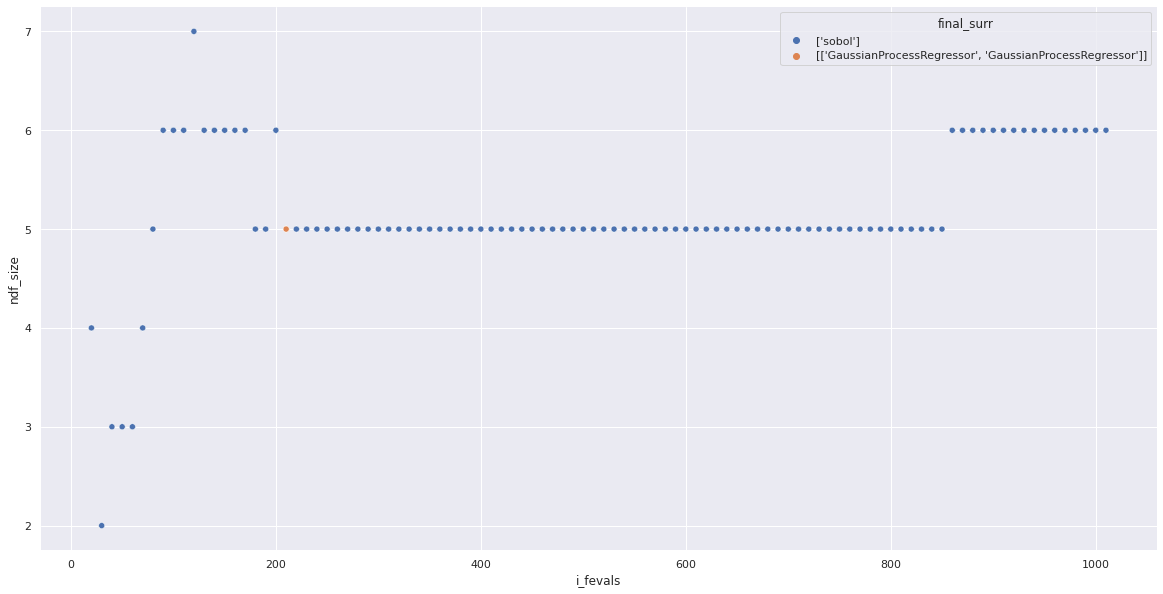

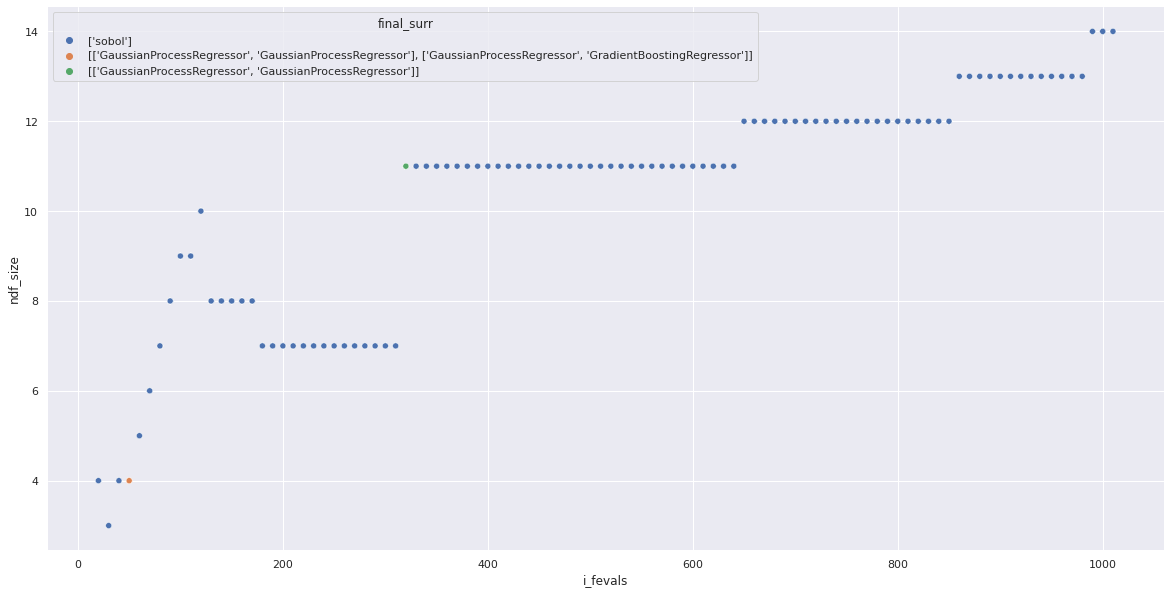

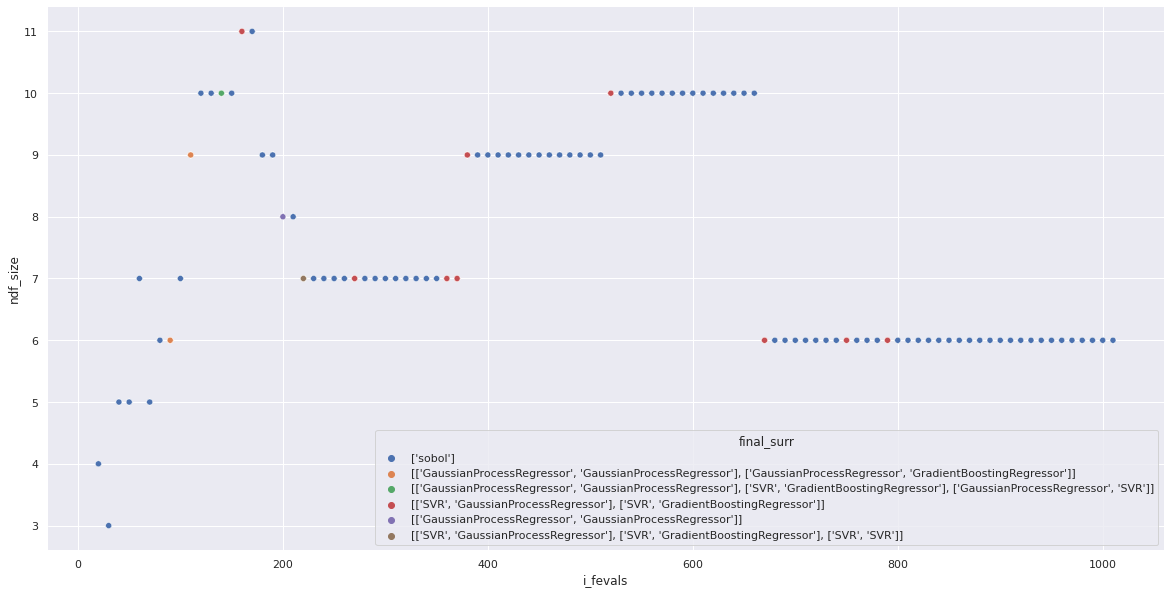

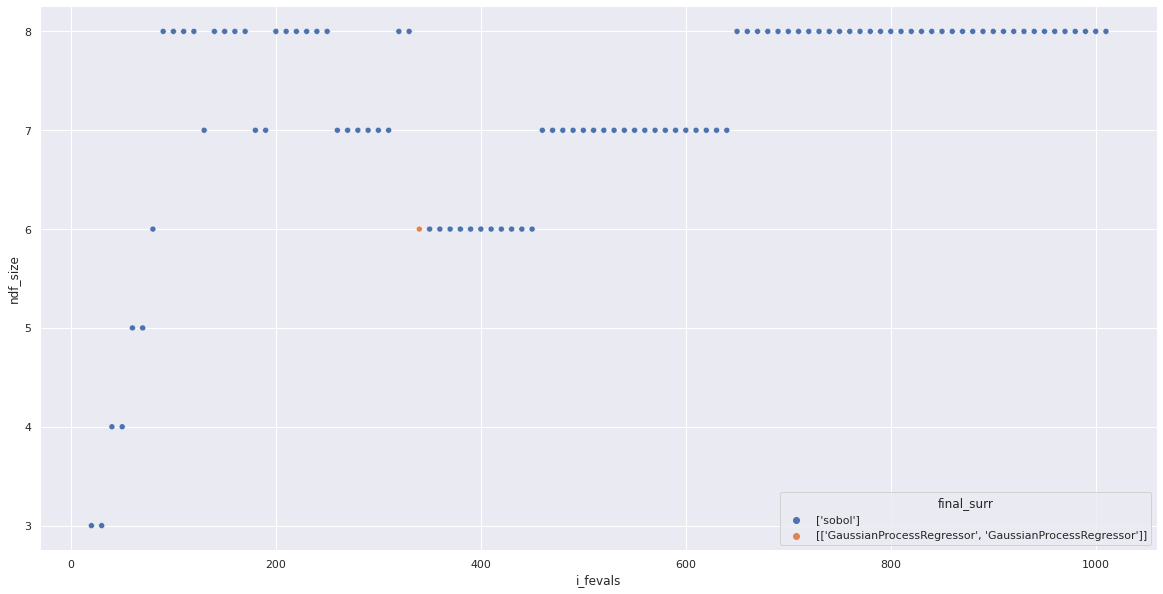

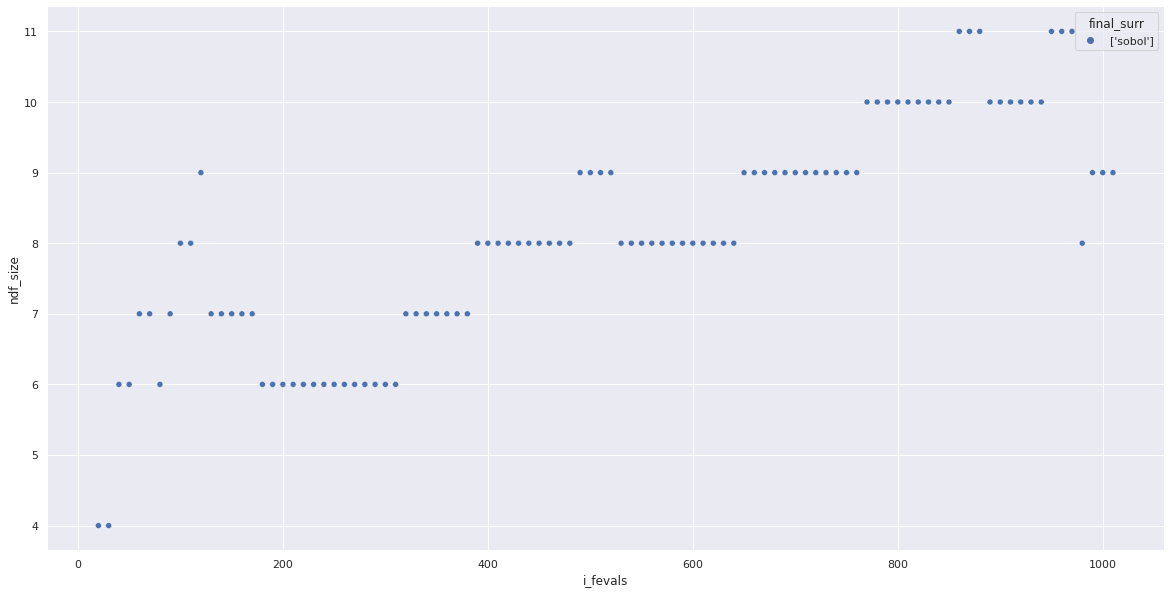

In [485]:
for l in figure_df.loop_id.unique():
    f, ax = plt.subplots(figsize=(20, 10))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x="i_fevals", y="ndf_size",
                    hue="final_surr",
                    data=figure_df[figure_df.loop_id==l], ax=ax)

In [385]:
df_4_merge = df.drop(columns=["feature_dim","i_time","model_id","params", "iteration"])

In [386]:
nsga_df_4_merge = nsga_df.drop(columns=["pop_f", "pop_size","i_gen", "time", "prob_id", "params"])

In [387]:
tutor_df_4_merge = tutor_df.drop(columns=["final_surr", "solution_pool","tutor_id", "i_time", "samples_count", "params", "loop_id"])

In [388]:
merged_df = pd.concat([df_4_merge, nsga_df_4_merge, tutor_df_4_merge])
merged_df['ndf_size_%'] = merged_df['ndf_size'] / merged_df['i_fevals'] * 100
merged_df['test_roc_auc_%'] = merged_df['test_roc_auc'] * 100
merged_df['fit_time_%'] = (merged_df['fit_time'] / merged_df.max()["fit_time"]) * 100

<AxesSubplot:xlabel='i_fevals', ylabel='ndf_size_%'>

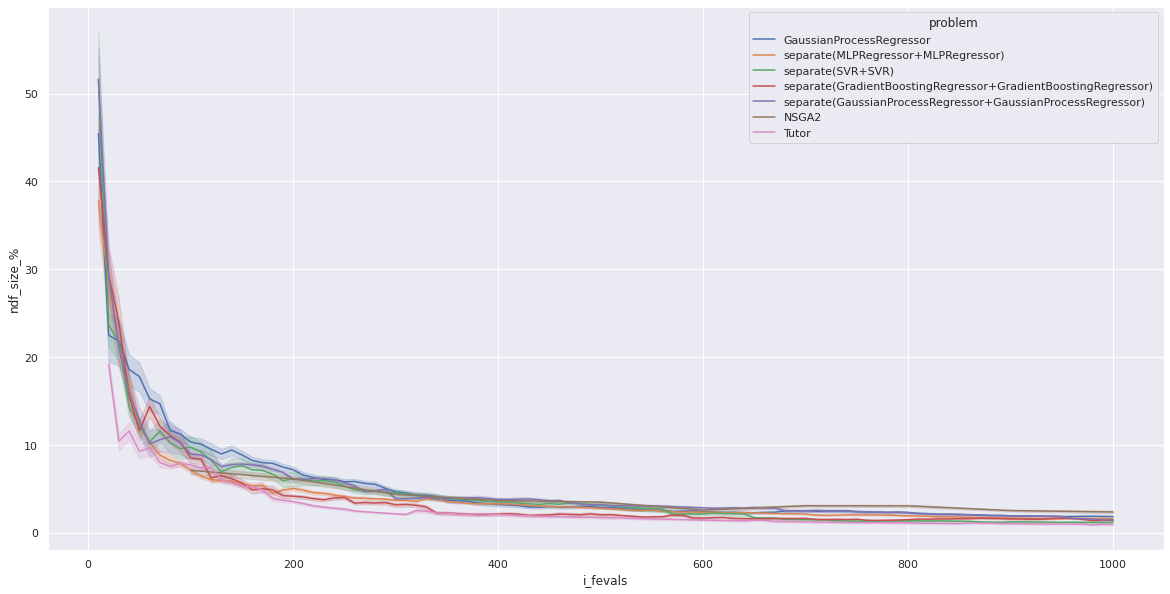

In [389]:
figure_df = merged_df[merged_df.i_fevals <= 1000]

f, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x="i_fevals", 
             y="ndf_size_%", 
             hue="problem",
             data=figure_df)

In [390]:
#integrate ndf_size_% surrogate-wise using the trapezodial rule
# NOTE integration is done in [0, 1000] evals interval
area_of_interest_df = merged_df[merged_df.i_fevals <= 1000]
merged_df["ndf_size_%_area"] = 0
for p in area_of_interest_df.problem.unique():
    problem_wise_df = area_of_interest_df[area_of_interest_df.problem == p]
    area = np.trapz(y=problem_wise_df["ndf_size_%"])
    merged_df["ndf_size_%_area"] = merged_df["ndf_size_%_area"].where(merged_df.problem != p, area)

In [391]:
# Hypervolume
# find a reference point = [1 - min roc_auc, max fit_time] 
# NOTE reference point for ALL data in [0, 50000] interval

ref_point = np.array([merged_df.max()["test_roc_auc"], merged_df.max()["fit_time"]])
ref_point


array([-0.5       ,  4.81895582])

In [392]:
merged_raw_df = merged_raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)

In [393]:
#integrate hypervolume surrogate-wise using the trapezodial rule
# NOTE integration is done in [0, 1000] evals interval

area_of_interest_df = merged_raw_df[merged_raw_df.i_fevals <= 1000]

merged_raw_df["hypervolume_area"] = 0
for p in merged_raw_df.problem.unique():
    problem_wise_df = area_of_interest_df[area_of_interest_df.problem == p]
    area = np.trapz(y=problem_wise_df["hypervolume"])
    merged_raw_df["hypervolume_area"] = merged_raw_df["hypervolume_area"].where(merged_raw_df.problem != p, area)

<AxesSubplot:xlabel='i_fevals', ylabel='hypervolume'>

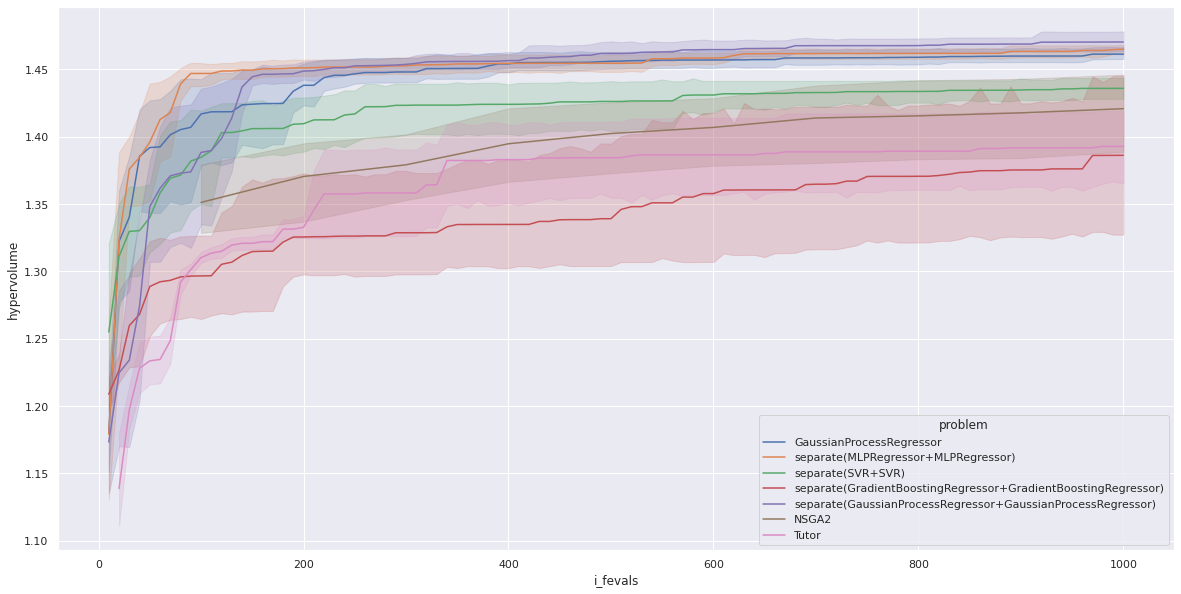

In [394]:
figure_df = merged_raw_df[merged_raw_df.i_fevals <= 1000]


f, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x="i_fevals", 
             y="hypervolume", 
             hue="problem",
             data=figure_df)

# sns.lineplot(x="iteration", 
#              y="test_roc_auc_%", 
# #              hue="model_id",
#              data=df)

# sns.lineplot(x="iteration", 
#              y="fit_time_%", 
# #              hue="model_id",
#              data=df)

# plt.legend(loc='upper left', labels=['ndf_size_%', 'test_roc_auc_%', 'fit_time_%'])

In [398]:
full_df = merged_df.merge(merged_raw_df)

In [399]:
# merged_df = df.merge(raw_df)
result_df = full_df[full_df.i_fevals==1000]
result_df = result_df.groupby(["problem"]).mean()
result_df

,ndf_size,i_fevals,test_roc_auc,fit_time,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,,,,,,,,,,
GaussianProcessRegressor,18.280000,1000.0,-0.770072,0.552725,1.828000,-77.007198,11.469808,28195.960944,1.460838,720.451088
NSGA2,23.769231,1000.0,-0.734495,0.096674,2.376923,-73.449487,2.006128,2781.971032,1.429838,68.513090
Tutor,8.818182,1000.0,-0.740627,0.597087,0.881818,-74.062680,12.390390,9324.445284,1.392443,673.991720
separate(GaussianProcessRegressor+GaussianProcessRegressor),14.307190,1000.0,-0.754423,0.107548,1.430719,-75.442260,2.231779,28024.208110,1.473060,721.058661
separate(GradientBoostingRegressor+GradientBoostingRegressor),15.271845,1000.0,-0.779479,0.080600,1.527184,-77.947923,1.672555,15682.947318,1.409624,669.647479
separate(MLPRegressor+MLPRegressor),16.669565,1000.0,-0.754005,0.127432,1.666957,-75.400521,2.644391,20168.486034,1.464345,723.652840
separate(SVR+SVR),11.969231,1000.0,-0.777339,0.458422,1.196923,-77.733911,9.512881,20555.646208,1.437327,707.560116


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

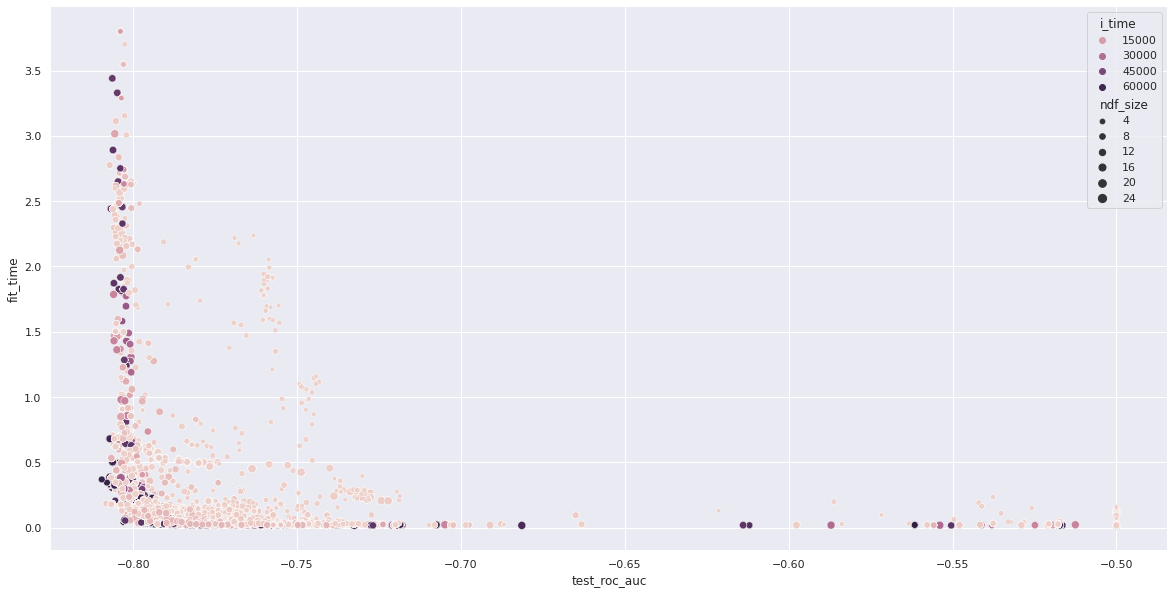

In [397]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                hue="i_time", size="ndf_size",
                data=df, ax=ax)

## Final results: all samples

In [459]:
data = get_data("results_paper/open_ml_1049/dataset.*.pkl")
data

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators,fit_time,score_time,test_f1,test_roc_auc
0,gini,61.000000,0.500000,0.250000,0.250000,sqrt,505,0.710772,0.094134,0.000000,0.858696
1,entropy,31.000000,0.750000,0.125000,0.375000,sqrt,752,0.972053,0.133970,0.000000,0.500000
2,gini,90.000000,0.250000,0.375000,0.125000,log2,257,0.373163,0.071908,0.000000,0.500000
3,gini,46.000000,0.625000,0.062500,0.437500,log2,133,0.186023,0.028879,0.000000,0.836822
4,entropy,105.000000,0.125000,0.312500,0.187500,sqrt,628,0.862586,0.116507,0.000000,0.788737
...,...,...,...,...,...,...,...,...,...,...,...
1005,entropy,59.098832,0.000047,0.000853,0.273343,sqrt,509,0.850374,0.114520,0.000000,0.875320
1006,entropy,58.341801,0.037465,0.000026,0.000225,sqrt,510,1.232074,0.106525,0.303726,0.931420
1007,entropy,59.098832,0.000018,0.013516,0.190025,sqrt,510,0.811232,0.100302,0.000000,0.882423
1008,entropy,59.655936,0.000018,0.000853,0.208446,sqrt,509,0.802147,0.100319,0.000000,0.877145


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

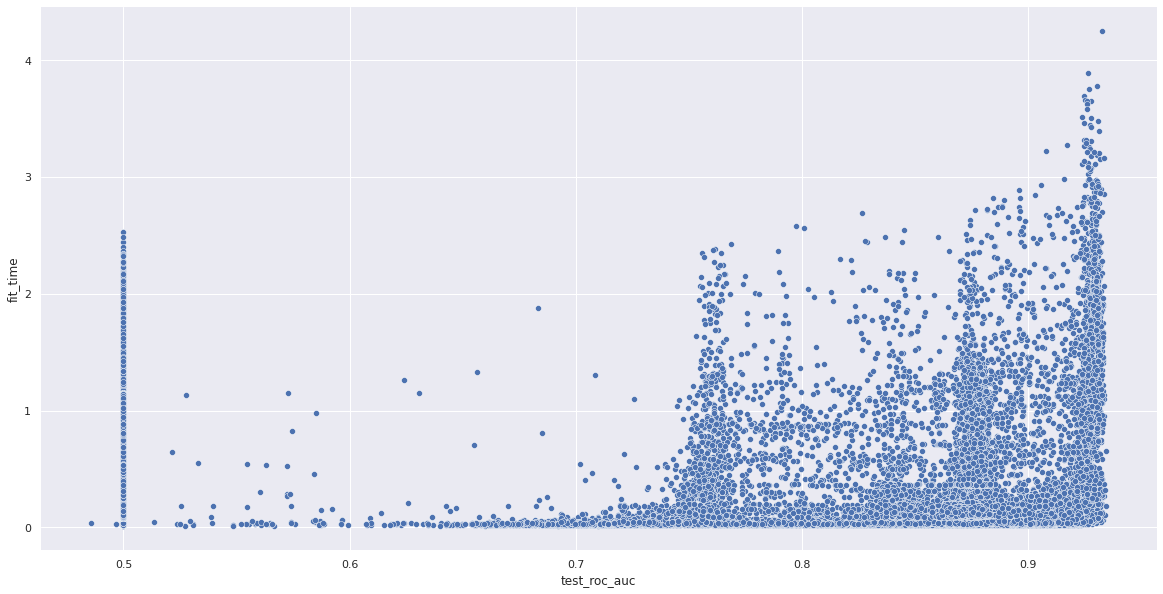

In [460]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                data=data, ax=ax)

In [401]:
### Table dataset-wise
# datasets = [1049, 1050, 31, 1471, 1510]
datasets = [31, 1510]

final_result = pd.DataFrame()
for d in datasets:
    raw_df = get_data("results_paper/open_ml_" + str(d) + "/*RF*.pkl")
    raw_df["ndf_f"].apply(lambda x: inverse(x))
    raw_df["i_fevals"] = raw_df["iteration"] * 10
    
    raw_nsga_df = get_data("results_paper/open_ml_" + str(d) + "/*NSGA*.pkl")
    raw_nsga_df["problem"] = "NSGA2"
    
    raw_tutor_df = get_data("results_paper/open_ml_" + str(d) + "/*loop*.pkl")
    raw_tutor_df["problem"] = "Tutor"
    obj = ['test_roc_auc', 'fit_time']
    raw_tutor_df = raw_tutor_df.apply(lambda x: set_objective(x), axis=1)
    raw_tutor_df["i_fevals"] = raw_tutor_df["samples_count"]
    raw_tutor_df["ndf_f"].apply(lambda x: inverse(x))
    
    raw_df_4_merge = raw_df.drop(columns=["feature_dim","i_time","model_id", "iteration", "ndf_x"])
    raw_nsga_df_4_merge = raw_nsga_df.drop(columns=["pop_f", "pop_size","i_gen", "time", "prob_id", "ndf_x"])
    raw_tutor_df_4_merge = raw_tutor_df.drop(columns=["final_surr", "solution_pool","tutor_id", "i_time", "samples_count", "ndf_x", "loop_id"])
    merged_raw_df = pd.concat([raw_df_4_merge, raw_nsga_df_4_merge, raw_tutor_df_4_merge])
    
    df = explode_ndf(raw_df)
    nsga_df = explode_ndf(raw_nsga_df)
    tutor_df = explode_ndf(raw_tutor_df)
    
    df_4_merge = df.drop(columns=["feature_dim","i_time","model_id","params", "iteration"])
    nsga_df_4_merge = nsga_df.drop(columns=["pop_f", "pop_size","i_gen", "time", "prob_id", "params"])
    tutor_df_4_merge = tutor_df.drop(columns=["final_surr", "solution_pool","tutor_id", "i_time", "samples_count", "params", "loop_id"])
    
    merged_df = pd.concat([df_4_merge, nsga_df_4_merge, tutor_df_4_merge])
    merged_df['ndf_size_%'] = merged_df['ndf_size'] / merged_df['i_fevals'] * 100
    merged_df['test_roc_auc_%'] = merged_df['test_roc_auc'] * 100
    merged_df['fit_time_%'] = (merged_df['fit_time'] / merged_df.max()["fit_time"]) * 100
    merged_df['dataset'] = d

    
    #integrate ndf_size_% surrogate-wise using the trapezodial rule
    # NOTE integration is done in [0, 1000] evals interval
    area_of_interest_df = merged_df[merged_df.i_fevals <= 1000]
    merged_df["ndf_size_%_area"] = 0
    for p in area_of_interest_df.problem.unique():
        problem_wise_df = area_of_interest_df[area_of_interest_df.problem == p]
        area = np.trapz(y=problem_wise_df["ndf_size_%"])
        merged_df["ndf_size_%_area"] = merged_df["ndf_size_%_area"].where(merged_df.problem != p, area)

    # Hypervolume
    # find a reference point = [1 - min roc_auc, max fit_time] 
    # NOTE reference point for ALL data in [0, 50000] interval

    ref_point = np.array([merged_df.max()["test_roc_auc"], merged_df.max()["fit_time"]])
   
    merged_raw_df = merged_raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1) 
    
    #integrate hypervolume area surrogate-wise using the trapezodial rule
    # NOTE integration is done in [0, 1000] evals interval

    area_of_interest_df = merged_raw_df[merged_raw_df.i_fevals <= 1000]
    merged_raw_df["hypervolume_area"] = 0
    for p in merged_raw_df.problem.unique():
        problem_wise_df = area_of_interest_df[area_of_interest_df.problem == p]
        area = np.trapz(y=problem_wise_df["hypervolume"])
        merged_raw_df["hypervolume_area"] = merged_raw_df["hypervolume_area"].where(merged_raw_df.problem != p, area)

    full_df = merged_df.merge(merged_raw_df)
    result_df = full_df[full_df.i_fevals==1000]
    result_df = result_df.groupby(["problem", 'dataset']).mean()

    final_result = pd.concat([final_result, result_df])
final_result    



,,ndf_size,i_fevals,test_roc_auc,fit_time,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,dataset,,,,,,,,,,
GaussianProcessRegressor,31,18.280000,1000.0,-0.770072,0.552725,1.828000,-77.007198,11.469808,28195.960944,1.460838,720.451088
NSGA2,31,23.769231,1000.0,-0.734495,0.096674,2.376923,-73.449487,2.006128,2781.971032,1.429838,68.513090
Tutor,31,8.818182,1000.0,-0.740627,0.597087,0.881818,-74.062680,12.390390,9324.445284,1.392443,673.991720
separate(GaussianProcessRegressor+GaussianProcessRegressor),31,14.307190,1000.0,-0.754423,0.107548,1.430719,-75.442260,2.231779,28024.208110,1.473060,721.058661
separate(GradientBoostingRegressor+GradientBoostingRegressor),31,15.271845,1000.0,-0.779479,0.080600,1.527184,-77.947923,1.672555,15682.947318,1.409624,669.647479
separate(MLPRegressor+MLPRegressor),31,16.669565,1000.0,-0.754005,0.127432,1.666957,-75.400521,2.644391,20168.486034,1.464345,723.652840
separate(SVR+SVR),31,11.969231,1000.0,-0.777339,0.458422,1.196923,-77.733911,9.512881,20555.646208,1.437327,707.560116
GaussianProcessRegressor,1510,12.457627,1000.0,-0.965952,0.045797,1.245763,-96.595236,0.832171,12252.671532,2.702170,1343.384356
NSGA2,1510,22.829787,1000.0,-0.926136,0.028442,2.282979,-92.613623,0.516828,2079.617063,2.681461,130.743235


In [402]:
# group all datasets
final_result = final_result.groupby(["problem"]).mean()
final_result 

,ndf_size,i_fevals,test_roc_auc,fit_time,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,,,,,,,,,,
GaussianProcessRegressor,15.368814,1000.0,-0.868012,0.299261,1.536881,-86.801217,6.150990,20224.316238,2.081504,1031.917722
NSGA2,23.299509,1000.0,-0.830316,0.062558,2.329951,-83.031555,1.261478,2430.794048,2.055649,99.628162
Tutor,9.306150,1000.0,-0.844125,0.596558,0.930615,-84.412450,11.610403,9158.394691,2.023403,1052.009743
separate(GaussianProcessRegressor+GaussianProcessRegressor),14.320261,1000.0,-0.822893,0.080678,1.432026,-82.289292,1.604765,27020.405859,1.943433,980.108138
separate(GradientBoostingRegressor+GradientBoostingRegressor),12.793580,1000.0,-0.880629,0.056420,1.279358,-88.062891,1.129201,14675.059221,2.049031,1003.295205
separate(MLPRegressor+MLPRegressor),14.558921,1000.0,-0.842932,0.112824,1.455892,-84.293225,2.214544,17191.595826,2.083490,1033.706998
separate(SVR+SVR),11.928012,1000.0,-0.870273,0.354734,1.192801,-87.027323,7.037325,18039.598172,2.044833,1012.181558
